#  Consider the following equation

Consider the following differential equation:

$$
\begin{aligned}
-\epsilon^2 U''(x) + e^{U(x)}-e^{-U(x)} &= 0 &  x \text{ in } (0, 1), \\
U(0) &= 0, \\
U(1) &= μ+  \int_{0}^{1} U(y) \, dy.
\end{aligned}
$$



In [ ]:
#!pip install pyDOE

In [ ]:
import torch
print('torch version = ', torch.__version__)
import torch.nn as nn

torch version =  2.2.1+cu121


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import random

from pyDOE import lhs

import numpy as np
from numpy.fft import fft,ifft,fftshift

#CUDA support
device = torch.device('cpu')
#device = torch.device('cuda:0')
print('device= ', device)

np.random.seed(1234) #生成指定隨機數
torch.set_default_dtype(torch.float64) #設置浮點類型


device=  cpu


In [ ]:
class Plain(nn.Module):

  def __init__(self, in_dim, h_dim , out_dim):
    super().__init__()
    self.ln1 = nn.Linear( in_dim , h_dim )
    self.act1 = nn.Sigmoid()
    self.ln2 = nn.Linear( h_dim , out_dim , bias = False )

  def forward(self, x):
    out = self.ln1(x)
    out = self.act1(out)
    out = self.ln2(out)
    return out


def count_parameters(model, requires_grad = True):
  """Count trainable parameters for a nn.Module."""
  if requires_grad:
      return sum(p.numel() for p in model.parameters() if p.requires_grad)
  return sum(p.numel() for p in model.parameters())

# **Boundary conditions**

$$
U(0) = 0 \text{ and, }U(1) = \mu + \int_{0}^{1}U(y)\text{d}y
$$

# **Loss function**

$$
\text{L} = λ_1 * \text{pde_loss} + λ_2 * (U(0)-0)^2 + λ_3 * [U(1) - ( \mu + \int_{0}^{1} U(y)\text{d}y) ]^2
$$

$$
\text{pde_loss } = -ϵ^2  U''(x) + e^{U(x)}-e^{-U(x)}
$$
$$
λ_1,λ_2,λ_3 \text{  is weight}
$$

In [ ]:
def loss(model, X_inner ):
  #方程參數 ϵ = 10**(-1)
  e = 10**(-1)
  #e = 1
  #權重
  lambda_1=1.0
  lambda_2=1.0
  lambda_3=1.0
  inner_pred = model(X_inner)
  dudX = torch.autograd.grad(
      inner_pred, X_inner,
      grad_outputs=torch.ones_like(inner_pred),
      retain_graph=True,
      create_graph=True
  )[0]  #u_x and u_y =u'
  dudX_xX = torch.autograd.grad(
      dudX[:,0], X_inner,
      grad_outputs=torch.ones_like(dudX[:,0]),
      retain_graph=True,
      create_graph=True
  )[0]  #u_xx and u_yy =u''
  laplace = dudX_xX

  #先假設方程參數mu = 1來看
  mu = 1
  residual = -e**2 * laplace[:, 0] + torch.exp(inner_pred.squeeze()) - torch.exp(-inner_pred.squeeze())
  inner_loss = lambda_1 * torch.mean(residual**2) #計算殘差平方和，及內部損失

  #邊界條件
  alpha = 0 #U(0)=α
  beta = mu + torch.mean(inner_pred) #U(1)= β

  #計算邊界處的值
  u_0 = model(torch.tensor([[0.0]], device=device)) #U(0)
  u_1 = model(torch.tensor([[1.0]], device=device)) #U(1)

  #計算邊界損失
  boundary_loss = lambda_2 * (u_0 - alpha)**2 + lambda_3 * (u_1 - beta)**2

  #總損失
  loss = inner_loss + boundary_loss

  return loss , inner_loss , boundary_loss , inner_pred


# **Training points**


In [ ]:
#number of grid points

N_training = 1000
X_training = lhs(1, N_training)

X_inner_torch = torch.from_numpy(X_training).requires_grad_(True).double().to(device)

# **Validation points**

In [ ]:
#validation set 驗證集
N_valid = N_training
X_valid = lhs(1, N_valid)

X_valid_inner_torch = torch.from_numpy(X_valid).requires_grad_(True).double().to(device)

# **The Network model**

In [ ]:
#神經網路隱藏層的神經元數量為...
N_neurons = 20

#single-layer model設置了一個單層神經網路模型
#輸入and 輸出 維度=1
model = Plain(1, N_neurons, 1).to(device)
print(model)
print(f"Number of paramters: {count_parameters(model)}")

Plain(
  (ln1): Linear(in_features=1, out_features=20, bias=True)
  (act1): Sigmoid()
  (ln2): Linear(in_features=20, out_features=1, bias=False)
)
Number of paramters: 60


# **Training with LBFGs optimizer**

In [ ]:
optimizerLBFGS = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1, # 學習率
    max_iter=2000, #最大迭代次數
    max_eval=2000, #最大函數評估次數
    history_size=50, #更新 history_size 預設為100
    tolerance_grad=-np.finfo(float).eps,#一階最優性的終止容差（默認值：1e-5）;加(-)號可迭帶到最大迭帶次數，因為值不會小於要停止的值
    tolerance_change=-np.finfo(float).eps, #函數值/參數更改的終止容差（默認值：1e-9 ）; 同上
    line_search_fn="strong_wolfe"       # can be "strong_wolfe"
)

In [ ]:
def loss_func_lbfgs():

    optimizerLBFGS.zero_grad() # L-BFGS的基本思想是只保存最近的m次迭代信息，从而大大减少數據的儲存空間
    global itera
    itera += 1

    lossLBFGS = loss(model, X_inner_torch)[0]
    lossLBFGS_valid = loss(model, X_valid_inner_torch)[0]

    if itera % 200 == 0: # 一次迭代----
        print(
            'Iter %5d, LossLBFGS: %.5e, Loss_Valid: %.5e' % (itera, lossLBFGS.item(), lossLBFGS_valid.item())
            )

    savedloss.append(lossLBFGS.item())
    savedloss_valid.append(lossLBFGS_valid.item())

    lossLBFGS.backward(retain_graph = True)

    return lossLBFGS

In [ ]:
itera = 0

savedloss = []
savedloss_valid = []

In [ ]:
%%time

model.train()

lossLBFGS = loss(model, X_inner_torch)[0]
lossLBFGS_valid = loss(model, X_valid_inner_torch)[0]


print('Iter %5d, LossLBFGS: %.5e, Loss_Valid: %.5e' % (itera, lossLBFGS.item(), lossLBFGS_valid.item()))

savedloss.append(lossLBFGS.item())
savedloss_valid.append(lossLBFGS_valid.item())

# Backward and optimize
optimizerLBFGS.step(loss_func_lbfgs)

Iter     0, LossLBFGS: 1.46181e+00, Loss_Valid: 1.46181e+00
Iter   200, LossLBFGS: 7.49778e-04, Loss_Valid: 7.51197e-04
Iter   400, LossLBFGS: 1.13502e-04, Loss_Valid: 1.13629e-04
Iter   600, LossLBFGS: 6.52323e-05, Loss_Valid: 6.52577e-05
Iter   800, LossLBFGS: 2.97706e-05, Loss_Valid: 2.97468e-05
Iter  1000, LossLBFGS: 9.89274e-06, Loss_Valid: 9.87642e-06
Iter  1200, LossLBFGS: 8.32591e-06, Loss_Valid: 8.30682e-06
Iter  1400, LossLBFGS: 7.39051e-06, Loss_Valid: 7.37619e-06
Iter  1600, LossLBFGS: 7.06283e-06, Loss_Valid: 7.05111e-06
Iter  1800, LossLBFGS: 6.74840e-06, Loss_Valid: 6.73639e-06
Iter  2000, LossLBFGS: 6.22791e-06, Loss_Valid: 6.21909e-06
CPU times: user 12.2 s, sys: 55.1 ms, total: 12.3 s
Wall time: 12.4 s


tensor([[1.4618]], grad_fn=<AddBackward0>)

# **Plotting the evolution of loss**

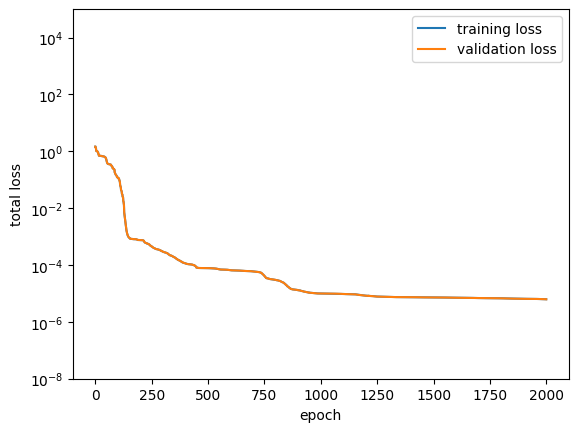

In [ ]:
start = 0
end = itera
idx = list(range(start, end, 1))

plt.figure()
plt.ylim(10**(-8), 10**5)
plt.yscale("log")
plt.plot(idx, savedloss[start:end], label = "training loss")
plt.plot(idx, savedloss_valid[start:end], label = "validation loss")
plt.xlabel('epoch')
plt.ylabel('total loss')
plt.legend()
plt.show()

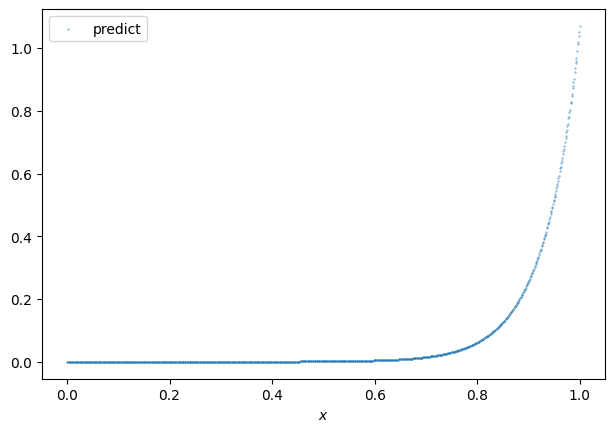

In [ ]:
# number of testing points
N_test = 1000

# Error at the interior points
x_test = lhs(1, N_test)


x_test_torch = torch.tensor(x_test).double().to(device)
u_pred = model(x_test_torch).detach().cpu().numpy()


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x_test, u_pred, s=0.1, label="predict")
ax1.set_xlabel("$x$")
ax1.legend()